In [219]:
import pandas as pd
from sklearn.metrics import *
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.stattools import adfuller
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import *
from sklearn.linear_model import *

import warnings
warnings.filterwarnings("ignore")

In [287]:
dataset = pd.read_csv('Dataset.csv', index_col = 'Tahun')
dataset.index = pd.to_datetime(dataset.index, format='%Y')
dataset.sort_index(ascending=True, inplace=True)
dataset = dataset.asfreq('AS')
dataset.head()

,IPM,RLS,UHH,HLS,Pengeluaran,IPG,IDG,Miskin,TPT,PDRB
Tahun,,,,,,,,,,
2010-01-01,79.69,9.79,74.43,15.42,13848.0,92.96,70.74,10.70,7.17,21481644.03
2011-01-01,80.04,10.03,74.44,15.45,13882.0,94.22,70.52,10.61,5.36,23764365.66
2012-01-01,80.10,10.03,74.46,15.48,13916.0,94.75,69.66,10.44,5.64,25732248.85
2013-01-01,80.26,10.03,74.47,15.52,14085.0,95.50,72.30,9.68,3.28,28295362.80
2014-01-01,80.70,10.28,74.47,15.64,14170.0,96.09,79.37,9.50,4.21,30912238.73


# Univariate ARIMA untuk peramalan faktor

In [221]:
 
def faktorarima(train, P, D, Q):
  Y = train.copy(deep =True)
  D = 0
  uji_adf_asli = adfuller(x = Y.dropna())
  print('Hasil Uji ADF Data Asli, P-value = ', uji_adf_asli[1])
  for orde_diff in range(1,6):
    if uji_adf_asli[1] < 0.05:
      break
    Y_diff = Y.diff(orde_diff)
    uji_adf_diff = adfuller(x = Y_diff.dropna())
    print(f'Hasil Uji ADF Data Differencing Orde {orde_diff}, P-value = ', uji_adf_diff[1])
    if uji_adf_diff[1] < 0.05 and uji_adf_diff[1] < uji_adf_asli[1]:
      D = orde_diff
      break
  
  print('Nilai D:', D)
  orde_arima = []
  rmse = []
  mae = []

  order_grid = list(product(range(max(P+1, Q+1)), repeat = 3))

  for order in order_grid:
    if (order[1] == D) and (order[0] <= P) and (order[2] <= Q):
      if not (order[0] == 0 and order[2] == 0):
        try:
          model = ARIMA(endog = train, order = order).fit()
          fitted = model.fittedvalues.drop(model.fittedvalues.index[0:D])
          rmse_train = np.sqrt(mean_squared_error(train.drop(train.index[0:D]), fitted))
          mae_train = mean_absolute_error(train.drop(train.index[0:D]), fitted)
          orde_arima.append(order)
          rmse.append(rmse_train)
          mae.append(mae_train)
        except:
          pass

  res = pd.DataFrame({'Orde ARIMA' : orde_arima,
                      'RMSE' : rmse,
                      'MAE': mae
                      })
  order = res[res['MAE'] == np.min(res['MAE'])]['Orde ARIMA'].tolist()[0]
  best_model = ARIMA(endog = train, order = order).fit()
  return(best_model.forecast(5))

In [222]:
faktor_ramalan = pd.DataFrame()
for col in dataset.columns:
    if col != 'IPM':
        print(col)
        faktor_ramalan[col] = faktorarima(dataset[col], 3, 3, 3).values

RLS
Hasil Uji ADF Data Asli, P-value =  0.8527299329861984
Hasil Uji ADF Data Differencing Orde 1, P-value =  3.169070430057541e-05
Nilai D: 1
UHH
Hasil Uji ADF Data Asli, P-value =  0.9978180569441597
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.7130534495123922
Hasil Uji ADF Data Differencing Orde 2, P-value =  0.7022137368866948
Hasil Uji ADF Data Differencing Orde 3, P-value =  0.9794351127941812
Hasil Uji ADF Data Differencing Orde 4, P-value =  0.8772084147421505
Hasil Uji ADF Data Differencing Orde 5, P-value =  0.9075006484384701
Nilai D: 0
HLS
Hasil Uji ADF Data Asli, P-value =  0.5143512577365273
Hasil Uji ADF Data Differencing Orde 1, P-value =  1.6988329356953743e-22
Nilai D: 1
Pengeluaran
Hasil Uji ADF Data Asli, P-value =  0.23051468303246941
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.10554118296309833
Hasil Uji ADF Data Differencing Orde 2, P-value =  0.015043707945631191
Nilai D: 2
IPG
Hasil Uji ADF Data Asli, P-value =  5.316931919147771e-07
Nilai D: 

# ARIMA-X

## ADF test dan Differencing

In [223]:
def differencing(Y, orde = 1):
    # Lakukan transformasi berupa differencing dengan orde yang ditentukan
    Y_diff = Y.diff(orde)

    # Lakukan Uji ADF terhadap data asli dan data hasil transformasi
    uji_adf_asli = adfuller(x = Y.dropna())
    uji_adf_diff = adfuller(x = Y_diff.dropna())

    print('Hasil Uji ADF Data Asli, P-value = ', uji_adf_asli[1])
    print(f'Hasil Uji ADF Data Differencing Orde {orde}, P-value = ', uji_adf_diff[1])

    # Tampilkan plot perbandingan
    fig, axs = plt.subplots(ncols = 2)
    axs[0].plot(Y, color = 'black')
    axs[0].set_title(f'{col}')
    axs[1].plot(Y_diff, color = 'red')
    axs[1].set_title(f'{col} Differencing Orde {orde}')

IPM
Hasil Uji ADF Data Asli, P-value =  0.9767144647056268
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.024841154543943072
RLS
Hasil Uji ADF Data Asli, P-value =  0.8527299329861984
Hasil Uji ADF Data Differencing Orde 1, P-value =  3.169070430057541e-05
UHH
Hasil Uji ADF Data Asli, P-value =  0.9978180569441597
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.7130534495123922
HLS
Hasil Uji ADF Data Asli, P-value =  0.5143512577365273
Hasil Uji ADF Data Differencing Orde 1, P-value =  1.6988329356953743e-22
Pengeluaran
Hasil Uji ADF Data Asli, P-value =  0.23051468303246941
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.10554118296309833
IPG
Hasil Uji ADF Data Asli, P-value =  5.316931919147771e-07
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.008992277307367435
IDG
Hasil Uji ADF Data Asli, P-value =  0.4380608128760041
Hasil Uji ADF Data Differencing Orde 1, P-value =  0.007619702787703115
Miskin
Hasil Uji ADF Data Asli, P-value =  0.6655050682232072
Hasil Uji

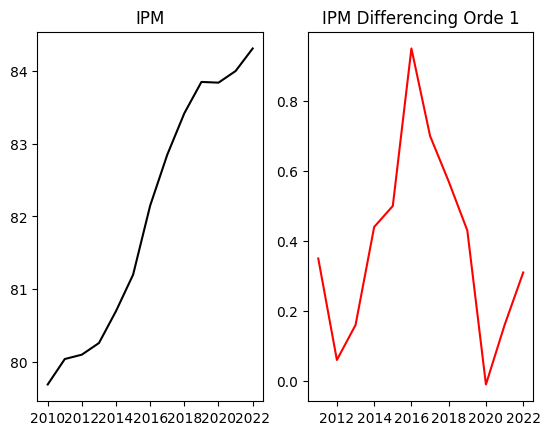

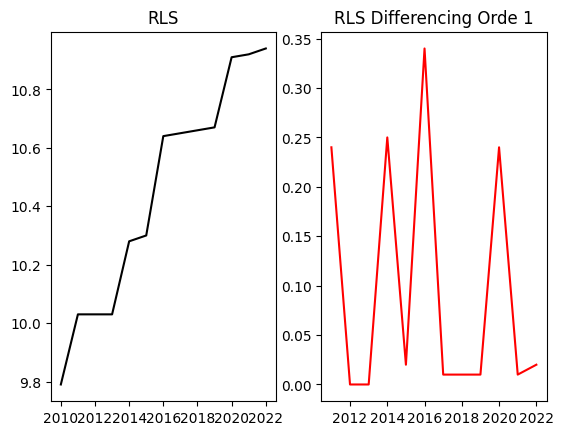

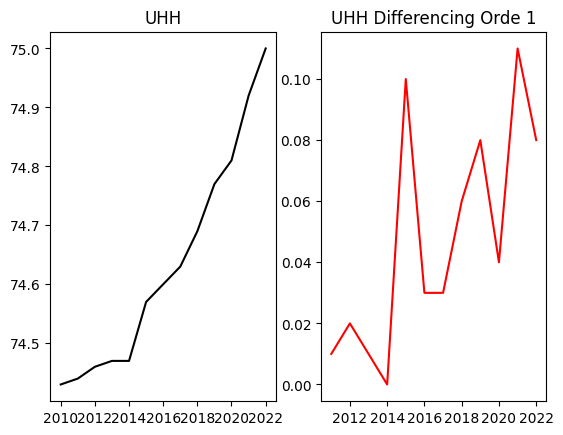

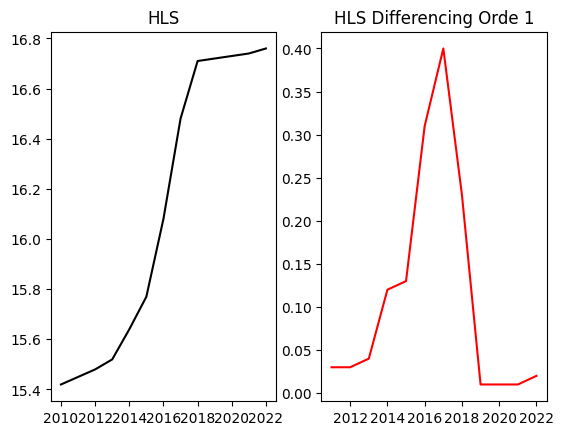

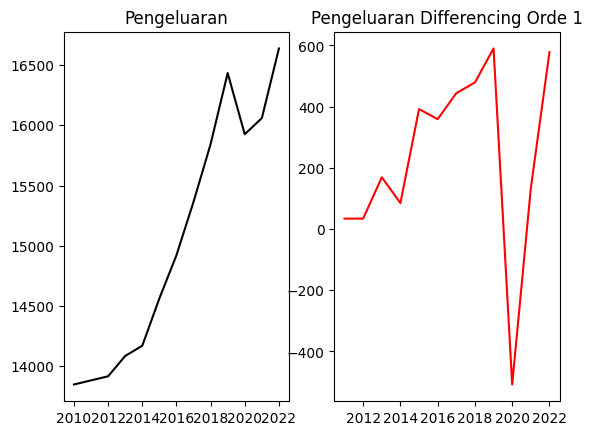

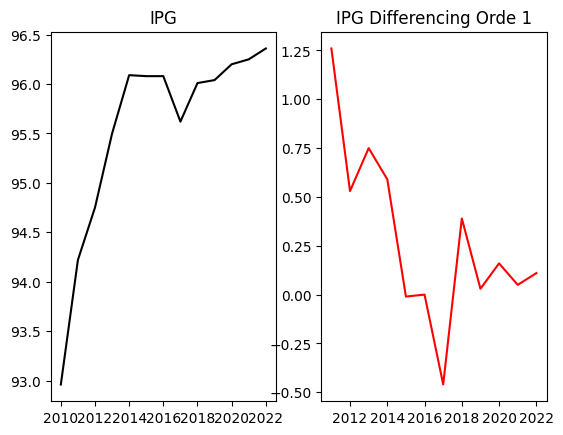

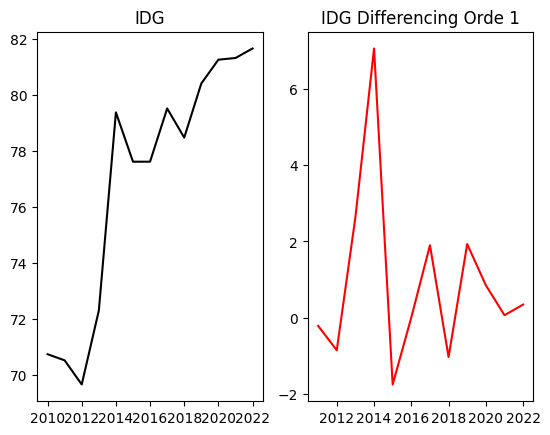

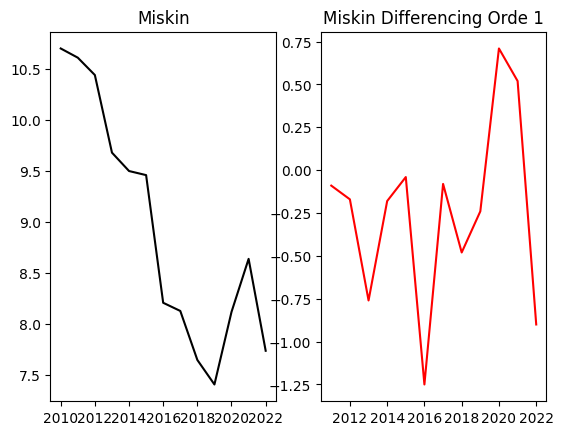

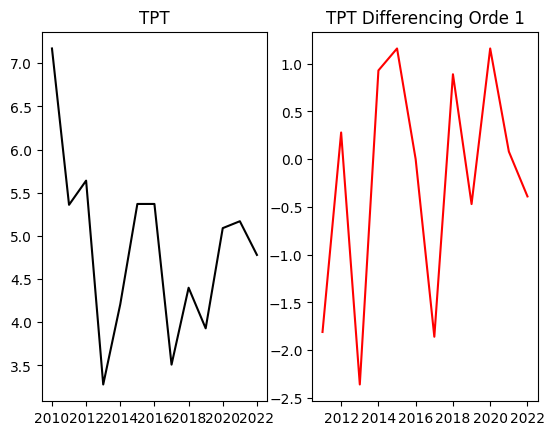

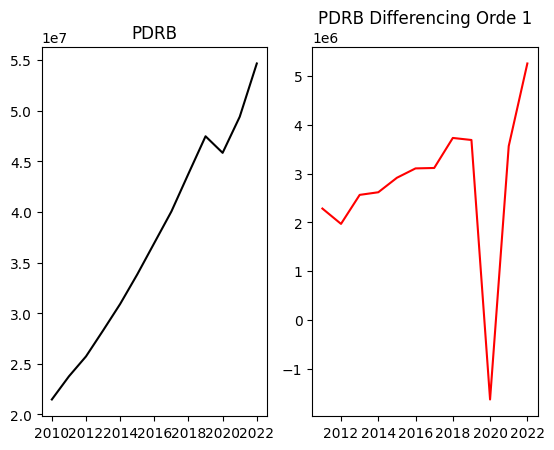

In [224]:
for col in dataset.columns:
    print(col)
    differencing(dataset[col])

## ACF dan PACF dari IPM

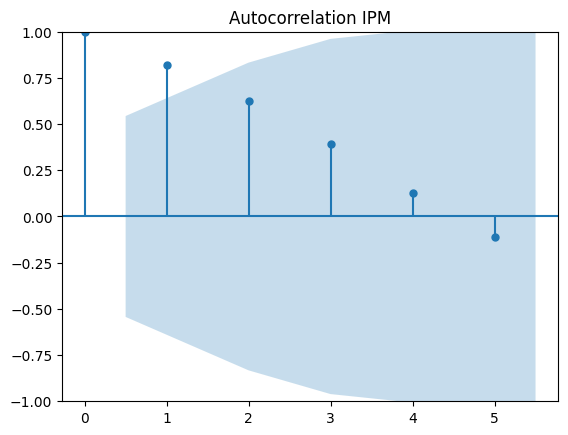

In [225]:
plot_acf(dataset['IPM'], lags=5, alpha = 0.05, title = 'Autocorrelation IPM')
plt.show()

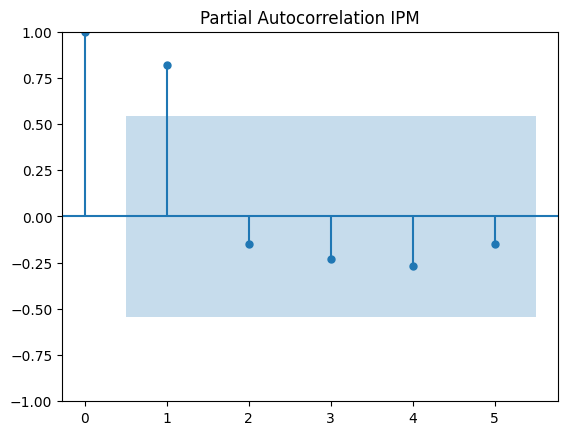

In [226]:
plot_pacf(dataset['IPM'], lags=5, alpha = 0.05, title = 'Partial Autocorrelation IPM')
plt.show()

## Fitting Model dan Eval

In [227]:
def autoarima(endog, P, D, Q, exog = None):
  orde_arima = []
  rmse = []
  mae = []

  order_grid = list(product(range(max(P+1, Q+1)), repeat = 3))

  for order in order_grid:
    if (order[1] == D) and (order[0] <= P) and (order[2] <= Q):
      if not (order[0] == 0 and order[2] == 0):
        try:
          print('Attempting to fit ARIMA', order)
          model = ARIMA(endog = endog, exog = exog, order = order).fit()
          fitted = model.fittedvalues.drop(model.fittedvalues.index[0:D])
          rmse_train = np.sqrt(mean_squared_error(endog.drop(endog.index[0:D]), fitted))
          mae_train = mean_absolute_error(endog.drop(endog.index[0:D]), fitted)
          orde_arima.append(order)
          rmse.append(rmse_train)
          mae.append(mae_train)
        except:
          print('Failed to fit ARIMA', order)
          pass

  return(pd.DataFrame({'Orde ARIMA' : orde_arima,
                      'RMSE' : rmse,
                      'MAE': mae
                      }))           

In [228]:
hasil_arima = autoarima(dataset['IPM'], 2, 1, 2)
hasil_arima.to_csv('arima.csv', index = False)
hasil_arima

Attempting to fit ARIMA (0, 1, 1)
Attempting to fit ARIMA (0, 1, 2)
Attempting to fit ARIMA (1, 1, 0)
Attempting to fit ARIMA (1, 1, 1)
Attempting to fit ARIMA (1, 1, 2)
Attempting to fit ARIMA (2, 1, 0)
Attempting to fit ARIMA (2, 1, 1)
Attempting to fit ARIMA (2, 1, 2)


,Orde ARIMA,RMSE,MAE
0,"(0, 1, 1)",0.309097,0.239865
1,"(0, 1, 2)",0.282581,0.237335
2,"(1, 1, 0)",0.256696,0.210186
3,"(1, 1, 1)",0.256544,0.210003
4,"(1, 1, 2)",0.241997,0.208897
5,"(2, 1, 0)",0.256539,0.210042
6,"(2, 1, 1)",0.252323,0.194488
7,"(2, 1, 2)",0.249752,0.195099


In [229]:
hasil_arimax = autoarima(dataset['IPM'], 2, 1, 2, dataset.drop('IPM', axis = 1))
hasil_arimax.to_csv('arimax.csv', index = False)
hasil_arimax

Attempting to fit ARIMA (0, 1, 1)
Attempting to fit ARIMA (0, 1, 2)
Attempting to fit ARIMA (1, 1, 0)
Attempting to fit ARIMA (1, 1, 1)
Attempting to fit ARIMA (1, 1, 2)
Attempting to fit ARIMA (2, 1, 0)
Attempting to fit ARIMA (2, 1, 1)
Attempting to fit ARIMA (2, 1, 2)


,Orde ARIMA,RMSE,MAE
0,"(0, 1, 1)",0.026373,0.022297
1,"(0, 1, 2)",0.024913,0.022046
2,"(1, 1, 0)",0.025491,0.021709
3,"(1, 1, 1)",0.045667,0.030015
4,"(1, 1, 2)",0.038626,0.027913
5,"(2, 1, 0)",0.023288,0.019800
6,"(2, 1, 1)",0.032886,0.025989
7,"(2, 1, 2)",0.037009,0.027292


## Diagnostic Check

In [230]:
model_arimax = ARIMA(endog = dataset['IPM'], exog = dataset.drop('IPM', axis = 1), order = (2,1,0)).fit()
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IPM   No. Observations:                   13
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  27.318
Date:                Fri, 09 Jun 2023   AIC                            -30.636
Time:                        10:50:28   BIC                            -24.817
Sample:                    01-01-2010   HQIC                           -32.790
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RLS             1.1197      0.016     70.070      0.000       1.088       1.151
UHH             1.1856      0.001   1103.191      0.000       1.183       1.188
HLS             1.2178      0.017     70.228      0.000       1.184       1.252
Pengeluaran     0.0008   6.88e-05     11.103      0.000       0.001       0.001
IPG             0.0814      0.028      2.882      0.004       0.026       0.137
IDG             0.0008      0.006      0.142      0.887      -0.010       0.012
Miskin          0.0182      0.025      0.725      0.468      -0.031       0.067
TPT            -0.0034      0.012     -0.289      0.773      -0.027       0.020
PDRB        -4.024e-08    8.7e-09     -4.627      0.000   -5.73e-08   -2.32e-08
ar.L1          -0.3674      0.003   -121.393      0.000      -0.373      -0.361
ar.L2           0.5186      0.001    348.220      0.000       0.516       0.522
sigma2          0.0006      0.001      0.979      0.328      -0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.91   Prob(JB):                         0.74
Heteroskedasticity (H):               1.70   Skew:                            -0.48
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+19. Standard errors may be unstable.
"""

## Forecast

In [231]:
# ARIMAX(2,1,0)
pred_forecast_arimax = model_arimax.predict(start = '2011', end = '2027', exog = faktor_ramalan)

In [232]:
# ARIMA(2,1,1)
model_arima = ARIMA(dataset['IPM'], order = (2,1,1)).fit()
pred_forecast_arima = model_arima.predict(start = '2011', end = '2027')

Text(0.5, 1.0, 'Ramalan IPM melalui ARIMA(2, 1, 1) dan ARIMA-X(2, 1, 0)')

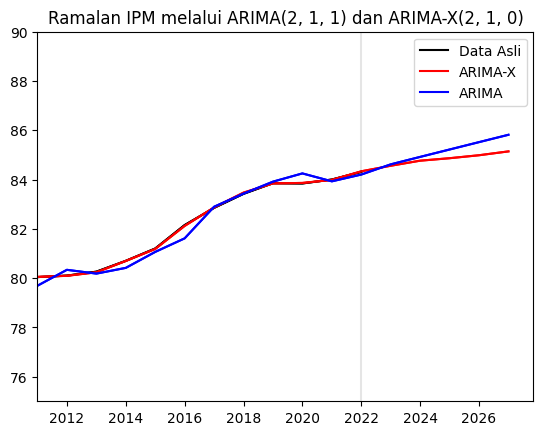

In [233]:
# Data Asli
(line1,) = plt.plot(dataset['IPM'], color = 'black')
plt.plot(dataset['IPM'], color = 'black')

# Ramalan ARIMA-X
(line2,) = plt.plot(pred_forecast_arimax, color = 'red')
plt.plot(pred_forecast_arimax, color = 'red')

# Ramalan ARIMA
(line3,) = plt.plot(pred_forecast_arima, color = 'blue')
plt.plot(pred_forecast_arima, color = 'blue')

plt.axvline(pd.to_datetime('2022', format = '%Y'), alpha = 0.1, color = 'black')
plt.legend([line1, line2, line3], ['Data Asli', 'ARIMA-X', 'ARIMA'])

plt.xlim(left = pd.to_datetime('2011', format='%Y'))
plt.ylim((75, 90))

plt.title('Ramalan IPM melalui ARIMA(2, 1, 1) dan ARIMA-X(2, 1, 0)')

In [234]:
pred_forecast_arimax

2011-01-01    80.048205
2012-01-01    80.091712
2013-01-01    80.234374
2014-01-01    80.694527
2015-01-01    81.180377
2016-01-01    82.114803
2017-01-01    82.869111
2018-01-01    83.469054
2019-01-01    83.843263
2020-01-01    83.861260
2021-01-01    83.984431
2022-01-01    84.333456
2023-01-01    84.558524
2024-01-01    84.764003
2025-01-01    84.864872
2026-01-01    84.985266
2027-01-01    85.141428
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [235]:
pred_forecast_arima

2011-01-01    79.690014
2012-01-01    80.335253
2013-01-01    80.181190
2014-01-01    80.414017
2015-01-01    81.061752
2016-01-01    81.611882
2017-01-01    82.895801
2018-01-01    83.428890
2019-01-01    83.913140
2020-01-01    84.247631
2021-01-01    83.926348
2022-01-01    84.201655
2023-01-01    84.615421
2024-01-01    84.917831
2025-01-01    85.218258
2026-01-01    85.517377
2027-01-01    85.815627
Freq: AS-JAN, Name: predicted_mean, dtype: float64

# skforecast

## Baseline

In [354]:
def sk(regressor, y, exog = None, lag = 1):
  forecaster = ForecasterAutoreg(
                  regressor = regressor,
                  lags = lag
                  )
  forecaster.fit(y, exog)
  metric, fitted = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = y,
                          exog               = exog,
                          steps              = 1,
                          metric             = ['mean_absolute_error', 'mean_squared_error'],
                          initial_train_size = None,
                          refit              = False,
                    )

  return(metric, fitted)

In [341]:
regressor = [LGBMRegressor(random_state = 13), RandomForestRegressor(random_state = 13), KNeighborsRegressor()]
rmse = []
mae = []
pred = []
fore = []

for reg in regressor:
  print(reg)
  metric, predictions = sk(reg, dataset['IPM'])
  rmse.append(np.sqrt(metric[1]))
  mae.append(metric[0])
  pred.append(predictions)

hasil = pd.DataFrame({
  'Model' : regressor,
  'MAE' : mae,
  'RMSE' : rmse
})
hasil

LGBMRegressor(random_state=13)


100%|██████████| 12/12 [00:00<00:00, 487.98it/s]

RandomForestRegressor(random_state=13)



100%|██████████| 12/12 [00:00<00:00, 64.62it/s]


KNeighborsRegressor()


100%|██████████| 12/12 [00:00<00:00, 350.23it/s]


,Model,MAE,RMSE
0,LGBMRegressor(random_state=13),1.485000,1.609821
1,"(DecisionTreeRegressor(max_features=1.0, rando...",0.108467,0.144383
2,KNeighborsRegressor(),0.267000,0.325601


# With Lag

In [302]:
regressor = [LGBMRegressor(random_state = 13), RandomForestRegressor(random_state = 13), KNeighborsRegressor(3)]
rmse = []
mae = []
pred = []

for reg in regressor:
  print(reg)
  metric, predictions = sk(reg, dataset['IPM'], lag = 10)
  rmse.append(np.sqrt(metric[1]))
  mae.append(metric[0])
  pred.append(predictions)

hasil = pd.DataFrame({
  'Model' : regressor,
  'MAE' : mae,
  'RMSE' : rmse
})
hasil

LGBMRegressor(random_state=13)


100%|██████████| 3/3 [00:00<00:00, 475.29it/s]

RandomForestRegressor(random_state=13)



100%|██████████| 3/3 [00:00<00:00, 61.52it/s]


KNeighborsRegressor(n_neighbors=3)


100%|██████████| 3/3 [00:00<00:00, 227.67it/s]


,Model,MAE,RMSE
0,LGBMRegressor(random_state=13),0.173333,0.195107
1,"(DecisionTreeRegressor(max_features=1.0, rando...",0.078467,0.085701
2,KNeighborsRegressor(n_neighbors=3),0.173333,0.195107


## With lag and exogenous

In [366]:
regressor = [LGBMRegressor(random_state = 11), RandomForestRegressor(random_state = 13), KNeighborsRegressor(2)]
rmse = []
mae = []
pred = []
fore = []

for reg in regressor:
  print(reg)
  metric, predictions = sk(reg, dataset['IPM'], lag = 9, exog = dataset.drop(['TPT', 'IDG' ,'IPM', 'IPG'], axis = 1))
  rmse.append(np.sqrt(metric[1]))
  mae.append(metric[0])
  pred.append(predictions)

hasil = pd.DataFrame({
  'Model' : regressor,
  'MAE' : mae,
  'RMSE' : rmse
})
hasil

LGBMRegressor(random_state=11)


100%|██████████| 4/4 [00:00<00:00, 185.28it/s]

RandomForestRegressor(random_state=13)



100%|██████████| 4/4 [00:00<00:00, 52.91it/s]


KNeighborsRegressor(n_neighbors=2)


100%|██████████| 4/4 [00:00<00:00, 108.47it/s]


,Model,MAE,RMSE
0,LGBMRegressor(random_state=11),0.155000,0.189868
1,"(DecisionTreeRegressor(max_features=1.0, rando...",0.043725,0.058805
2,KNeighborsRegressor(n_neighbors=2),0.060000,0.086168


## Feature Importance

In [485]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=13),
                lags = 9
                )
forecaster.fit(dataset['IPM'], dataset.drop('IPM', axis = 1))

In [486]:
forecaster.get_feature_importance().sort_values('importance', ascending=False)

,feature,importance
10,UHH,0.111513
9,RLS,0.077411
4,lag_5,0.077106
17,PDRB,0.073745
1,lag_2,0.072305
6,lag_7,0.064628
15,Miskin,0.063733
8,lag_9,0.063111
5,lag_6,0.060087
11,HLS,0.059473


Text(0.5, 1.0, 'Feature Importance')

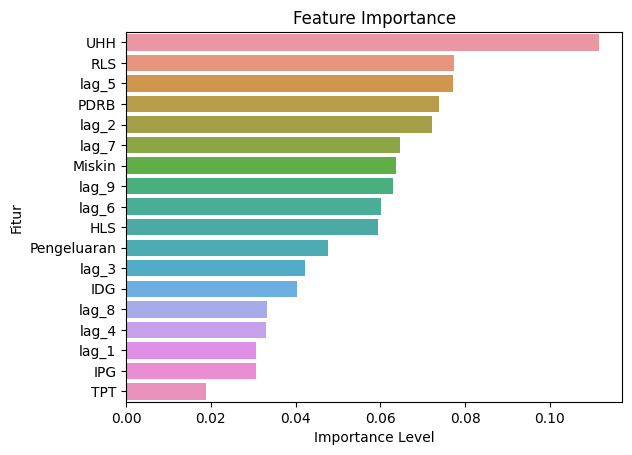

In [487]:
import seaborn as sns

sns.barplot(forecaster.get_feature_importance().sort_values('importance', ascending=False), x = 'importance', y = 'feature')
plt.xlabel('Importance Level')
plt.ylabel('Fitur')
plt.title('Feature Importance')

## Forecast

In [475]:
def skf(regressor, y, exog = None, lag = 9, exog_pred = None):
  forecaster = ForecasterAutoreg(
                  regressor = regressor,
                  lags = lag
                  )
  forecaster.fit(y, exog)
  forecast = forecaster.predict(steps = 1, exog = exog_pred)+0.3
  next_y = pd.concat([y, forecast], axis = 0)
  next_exog = pd.concat([exog, exog_pred], axis = 0)
  return(next_y, next_exog)

In [476]:
ml_exogen = faktor_ramalan.copy(deep=True)
ml_exogen.index = pd.to_datetime([2023,2024,2025,2026,2027], format='%Y')
ml_exogen = ml_exogen.asfreq('AS')
ml_exogen.drop(['TPT', 'IDG' ,'IPG'], axis = 1, inplace = True)

In [477]:
# Random Forest
next_y = dataset['IPM'].copy()
next_exog = dataset.drop(['TPT', 'IDG' ,'IPM', 'IPG'], axis = 1)
for i in range(1, 6):
  next_y, next_exog = skf(RandomForestRegressor(random_state=13), next_y, exog = next_exog, exog_pred =ml_exogen.iloc[(i-1):i,:])
rf_forecast = next_y.copy()

# LGBM
next_y = dataset['IPM'].copy()
next_exog = dataset.drop(['TPT', 'IDG' ,'IPM', 'IPG'], axis = 1)
for i in range(1, 6):
  next_y, next_exog = skf(LGBMRegressor(random_state=13), next_y, exog = next_exog, exog_pred =ml_exogen.iloc[(i-1):i,:])
lgb_forecast = next_y.copy()

# kNN
next_y = dataset['IPM'].copy()
next_exog = dataset.drop(['TPT', 'IDG' ,'IPM', 'IPG'], axis = 1)
for i in range(1, 6):
  next_y, next_exog = skf(KNeighborsRegressor(2), next_y, exog = next_exog, exog_pred =ml_exogen.iloc[(i-1):i,:])
knn_forecast = next_y.copy()

Text(0.5, 1.0, 'Ramalan IPM')

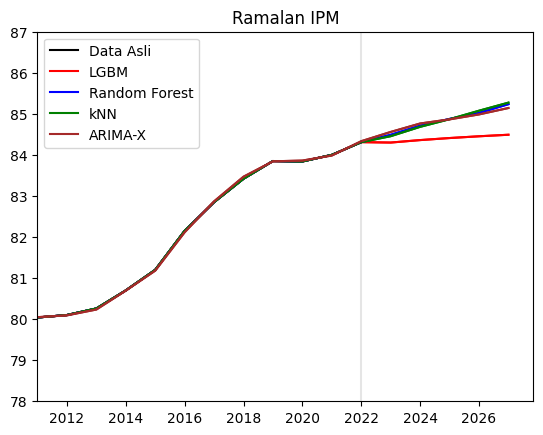

In [479]:
# Data Asli
(line1,) = plt.plot(dataset['IPM'], color = 'black')
plt.plot(dataset['IPM'], color = 'black')

# Ramalan LGBM
(line2,) = plt.plot(lgb_forecast, color = 'red')
plt.plot(lgb_forecast, color = 'red')

# Ramalan RF
(line3,) = plt.plot(rf_forecast, color = 'blue')
plt.plot(rf_forecast, color = 'blue')

# Ramalan kNN
(line4,) = plt.plot(knn_forecast, color = 'green')
plt.plot(knn_forecast, color = 'green')

# Ramalan ARIMA-X
(line5,) = plt.plot(pred_forecast_arimax, color = 'brown')
plt.plot(pred_forecast_arimax, color = 'brown')

plt.axvline(pd.to_datetime('2022', format = '%Y'), alpha = 0.1, color = 'black')
plt.legend([line1, line2, line3, line4, line5], ['Data Asli', 'LGBM', 'Random Forest', 'kNN', 'ARIMA-X'])

plt.xlim(left = pd.to_datetime('2011', format='%Y'))
plt.ylim((78, 87))

plt.title('Ramalan IPM')

In [483]:
pd.concat([pred_forecast_arimax, rf_forecast, lgb_forecast, knn_forecast], axis = 1).to_csv('Forecast.csv', index = True)